# Embedded ML - Lab 1.2: Model Compression

In this lab you are asked to create a compressed verion of an ANNs model. You are not allowed to use ML libraries such as SciKit-learn, PyTorch or TensorFlow, but you are allowed to use standard libraries such as math, numpy and matplotlib if needed. You are given some code but you are expected to write some more and be able to explain and modify everything. This lab is essential for you to grasp the details of some of the most important techniques for compressing or making ML models more efficient: quantization and pruning.

### Learning outcomes


* Explain the basic concepts of compression in ANNs
* Apply range tuning and centering when doing quantization
* Calculate and analyze the impact of quantization and pruning on memory and computing

### Naive quantization
Quantization means reducing the precission of model parameters and mainly targets weights, since they represent the most volumne of memory and processing in ANNs.

Take the code from the last part of Lab 1.1 (MNIST model) and add methods to export and import weights to and from a binary file, making sure both processes work with your code in such a way that you don't have to train every time you want to run inference, but insted, the wieghts are loaded into the model when needed. Investigate which serialization/desarialization options exist in Python and choose one that you understand.

Then, create two additional inference methods: FP16 and INT8. The FP16 method should treat all computations in the network involving the weights, as 16-bit floating-point. The INT8 method should work with 8-bit integers instead. In both cases, use the native datatype conversion methods. Investigate the NumPy methods available to enforce the desired datatypes.

Run the two quantized models and compare them with the baseline in terms of model size, accuracy and latency.

In [1]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, dtype=np.float32):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dtype = dtype
        self.init_weights()

    def saturate(self, x):
        """Saturate values to the limits of the dtype."""
        if self.dtype == np.int8:
            return np.clip(x, -128, 127).astype(np.int8)
        return x.astype(self.dtype)

    def init_weights(self):
        self.weights_input_hidden = self.saturate(np.random.randn(self.input_size, self.hidden_size) * 0.01)
        self.bias_input_hidden = self.saturate(np.zeros((1, self.hidden_size)))
        self.weights_hidden_output = self.saturate(np.random.randn(self.hidden_size, self.output_size) * 0.01)
        self.bias_hidden_output = self.saturate(np.zeros((1, self.output_size)))

    def my_dot(self, A, B):
        A = A.astype(np.int16 if self.dtype == np.int8 else self.dtype)
        B = B.astype(np.int16 if self.dtype == np.int8 else self.dtype)
        if A.ndim == 1:
            A = A.reshape(1, -1)
        result = np.zeros((A.shape[0], B.shape[1]), dtype=A.dtype)
        for i in range(A.shape[0]):
            for j in range(B.shape[1]):
                for k in range(A.shape[1]):
                    result[i, j] += A[i, k] * B[k, j]
        return self.saturate(result)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, x):
        x = x.astype(np.int16 if self.dtype == np.int8 else self.dtype)
        self.hidden_input = self.my_dot(x, self.weights_input_hidden) + self.bias_input_hidden
        self.hidden_output = self.saturate(self.sigmoid(self.hidden_input.astype(np.float32)))

        self.final_input = self.my_dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output
        self.output = self.saturate(self.sigmoid(self.final_input.astype(np.float32)))

        return self.output

    def backward(self, x, y, output, learning_rate):
        self.error = y - output
        d_output = self.error * self.sigmoid_derivative(output.astype(np.float32))
        d_output = self.saturate(d_output)

        self.hidden_error = d_output.dot(self.weights_hidden_output.T)
        d_hidden = self.hidden_error * self.sigmoid_derivative(self.hidden_output.astype(np.float32))
        d_hidden = self.saturate(d_hidden)

        self.weights_hidden_output += self.saturate(self.hidden_output.T.dot(d_output) * learning_rate)
        self.bias_hidden_output += self.saturate(np.sum(d_output, axis=0, keepdims=True) * learning_rate)
        self.weights_input_hidden += self.saturate(x.T.dot(d_hidden) * learning_rate)
        self.bias_input_hidden += self.saturate(np.sum(d_hidden, axis=0, keepdims=True) * learning_rate)

    def train(self, x, y, epochs, learning_rate):
        error = 0
        for epoch in range(epochs):
            output = self.forward(x)
            self.backward(x, y, output, learning_rate)
            if epoch % 10 == 0:
                error = np.mean(np.square(y - output))
                print(f'Epoch {epoch}: Loss = {error:.4f}')
        print(f'Epoch {epochs}: Loss = {error:.4f} ')

    def save_all_weights(self, filename="model_weights.npz"):
        np.savez(
            filename,
            wih=self.weights_input_hidden,
            bih=self.bias_input_hidden,
            who=self.weights_hidden_output,
            bho=self.bias_hidden_output
        )

    def load_all_weights(self, filename="model_weights.npz"):
        data = np.load(filename)
        self.weights_input_hidden = self.saturate(data['wih'])
        self.bias_input_hidden = self.saturate(data['bih'])
        self.weights_hidden_output = self.saturate(data['who'])
        self.bias_hidden_output = self.saturate(data['bho'])


    def set_dtype(self, dtype):
        self.dtype = dtype
        self.weights_input_hidden = self.saturate(self.weights_input_hidden)
        self.bias_input_hidden = self.saturate(self.bias_input_hidden)
        self.weights_hidden_output = self.saturate(self.weights_hidden_output)
        self.bias_hidden_output = self.saturate(self.bias_hidden_output)


In [2]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# === Load and preprocess MNIST dataset ===
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_data = mnist.data / 255.0
y_data = mnist.target.astype(np.int32)

# Reduce dataset size for faster training with random selection
X_data = X_data[:1000]
y_data = y_data[:1000]

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_data_encoded = encoder.fit_transform(y_data.reshape(-1, 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_encoded, test_size=0.1, random_state=20)

# === Run experiments with different hidden layer sizes ===
h_size = 10
results = []

# Define parameters

 #Number of features (28*28=784)
input_size = X_train.shape[1]
# Number of classes (based on one-hot encoding)
output_size = 10
# Number of epochs
epochs = 1000
# Learning rate
learning_rate = 0.01

# 
labels = np.argmax(y_test, axis=1)

Loading MNIST dataset...


In [17]:

print(f"\nTraining model with {h_size} hidden neurons...")
nn = NeuralNetwork(input_size=input_size, hidden_size=h_size, output_size=output_size)

start_train = time.time()
nn.train(X_train, y_train, epochs=epochs, learning_rate=learning_rate)
end_train = time.time()

# Time one forward pass
start_forward = time.time()
output = nn.forward(X_test[:1])
end_forward = time.time()

# Predict and evaluate accuracy
predictions = np.argmax(nn.forward(X_test), axis=1)
print("Predictions: ", predictions)

labels = np.argmax(y_test, axis=1)
print("Labels: ", labels)
accuracy = np.mean(predictions == labels) * 100

# Count parameters and forward operations
param_count = (2 * input_size * h_size) + (2 * h_size * output_size) + (h_size + output_size)
forward_ops = 2*input_size*h_size + 3*h_size + 2

results.append({
    "Hidden Neurons": h_size,
    "Parameters": param_count,
    "Forward Ops": forward_ops,
    "Training Time (s)": round(end_train - start_train, 2),
    "Forward Time (ms)": round((end_forward - start_forward) * 1000, 2),
    "Accuracy (%)": round(accuracy, 2)
})

# === Display results table ===
df = pd.DataFrame(results)
print("\nModel Comparison Table:")
print(df.to_string(index=False))

# === Save weights to binary files ===
print("Saving weights to binary files...")
nn.save_all_weights("weights_fp32.npz")


Training model with 10 hidden neurons...
Epoch 0: Loss = 0.2511
Epoch 10: Loss = 0.0904
Epoch 20: Loss = 0.0897
Epoch 30: Loss = 0.0882
Epoch 40: Loss = 0.0830
Epoch 50: Loss = 0.0732
Epoch 60: Loss = 0.0655
Epoch 70: Loss = 0.0589
Epoch 80: Loss = 0.0513
Epoch 90: Loss = 0.0478
Epoch 100: Loss = 0.0394
Epoch 110: Loss = 0.0350
Epoch 120: Loss = 0.0315
Epoch 130: Loss = 0.0285
Epoch 140: Loss = 0.0258
Epoch 150: Loss = 0.0239
Epoch 160: Loss = 0.0212
Epoch 170: Loss = 0.0190
Epoch 180: Loss = 0.0174
Epoch 190: Loss = 0.0162
Epoch 200: Loss = 0.0147
Epoch 210: Loss = 0.0136
Epoch 220: Loss = 0.0127
Epoch 230: Loss = 0.0118
Epoch 240: Loss = 0.0110
Epoch 250: Loss = 0.0102
Epoch 260: Loss = 0.0096
Epoch 270: Loss = 0.0090
Epoch 280: Loss = 0.0086
Epoch 290: Loss = 0.0081
Epoch 300: Loss = 0.0077
Epoch 310: Loss = 0.0073
Epoch 320: Loss = 0.0070
Epoch 330: Loss = 0.0067
Epoch 340: Loss = 0.0064
Epoch 350: Loss = 0.0061
Epoch 360: Loss = 0.0058
Epoch 370: Loss = 0.0056
Epoch 380: Loss = 0

In [3]:
#Load weights from binary file
model_fp32 = NeuralNetwork(input_size=input_size, hidden_size=h_size, output_size=output_size, dtype=np.float32)
model_fp32.load_all_weights("weights_fp32.npz")

model_fp16 = NeuralNetwork(input_size=input_size, hidden_size=h_size, output_size=output_size, dtype=np.float16)
model_fp16.load_all_weights("weights_fp32.npz")

model_int8 = NeuralNetwork(input_size=input_size, hidden_size=h_size, output_size=output_size, dtype=np.int8)
model_int8.load_all_weights("weights_fp32.npz")

# Print range of weights and biases
print("\nWeights and biases range:")
print("FP32 Weights Input-Hidden: ", model_fp32.weights_input_hidden.min(), model_fp32.weights_input_hidden.max())
print("FP32 Bias Input-Hidden: ", model_fp32.bias_input_hidden.min(), model_fp32.bias_input_hidden.max())
print("FP32 Weights Hidden-Output: ", model_fp32.weights_hidden_output.min(), model_fp32.weights_hidden_output.max())
print("FP32 Bias Hidden-Output: ", model_fp32.bias_hidden_output.min(), model_fp32.bias_hidden_output.max())
print("--------------------------------------------------")
print("FP16 Weights Input-Hidden: ", model_fp16.weights_input_hidden.min(), model_fp16.weights_input_hidden.max())
print("FP16 Bias Input-Hidden: ", model_fp16.bias_input_hidden.min(), model_fp16.bias_input_hidden.max())
print("FP16 Weights Hidden-Output: ", model_fp16.weights_hidden_output.min(), model_fp16.weights_hidden_output.max())
print("FP16 Bias Hidden-Output: ", model_fp16.bias_hidden_output.min(), model_fp16.bias_hidden_output.max())
print("--------------------------------------------------")
print("INT8 Weights Input-Hidden: ", model_int8.weights_input_hidden.min(), model_int8.weights_input_hidden.max())
print("INT8 Bias Input-Hidden: ", model_int8.bias_input_hidden.min(), model_int8.bias_input_hidden.max())
print("INT8 Weights Hidden-Output: ", model_int8.weights_hidden_output.min(), model_int8.weights_hidden_output.max())
print("INT8 Bias Hidden-Output: ", model_int8.bias_hidden_output.min(), model_int8.bias_hidden_output.max())

# # Multiply weights and biases by 10 for INT8 before loading from file with FP32
# model_int8.weights_input_hidden = model_int8.saturate(model_fp32.weights_input_hidden * 10)
# model_int8.bias_input_hidden = model_int8.saturate(model_fp32.bias_input_hidden * 10)
# model_int8.weights_hidden_output = model_int8.saturate(model_fp32.weights_hidden_output * 10)
# model_int8.bias_hidden_output = model_int8.saturate(model_fp32.bias_hidden_output * 10)

# # Print range of weights and biases after scaling
# print("\nWeights and biases range after scaling:")
# print("INT8 Weights Input-Hidden: ", model_int8.weights_input_hidden.min(), model_int8.weights_input_hidden.max())
# print("INT8 Bias Input-Hidden: ", model_int8.bias_input_hidden.min(), model_int8.bias_input_hidden.max())
# print("INT8 Weights Hidden-Output: ", model_int8.weights_hidden_output.min(), model_int8.weights_hidden_output.max())
# print("INT8 Bias Hidden-Output: ", model_int8.bias_hidden_output.min(), model_int8.bias_hidden_output.max())



Weights and biases range:
FP32 Weights Input-Hidden:  -1.062898 1.2112243
FP32 Bias Input-Hidden:  -0.9975036 0.49849313
FP32 Weights Hidden-Output:  -6.2362213 4.951678
FP32 Bias Hidden-Output:  -3.4558628 -0.7425632
--------------------------------------------------
FP16 Weights Input-Hidden:  -1.0625 1.211
FP16 Bias Input-Hidden:  -0.9976 0.4985
FP16 Weights Hidden-Output:  -6.234 4.953
FP16 Bias Hidden-Output:  -3.455 -0.7427
--------------------------------------------------
INT8 Weights Input-Hidden:  -1 1
INT8 Bias Input-Hidden:  0 0
INT8 Weights Hidden-Output:  -6 4
INT8 Bias Hidden-Output:  -3 0


In [4]:

# Input data for testing
input_data_fp32 = X_test.astype(np.float32)
input_data_fp16 = X_test.astype(np.float16)
input_data_int8 = X_test.astype(np.int8)

# Test the models with the same input data
models = {
    "FP32": model_fp32,
    "FP16": model_fp16,
    "INT8": model_int8
}

# Store results
results = []

for model_name, model in models.items():
    start_forward = time.time()
    output = model.forward(input_data_fp32 if model_name == "FP32" else input_data_fp16 if model_name == "FP16" else input_data_int8)
    end_forward = time.time()

    if model_name == "INT8":
        # Decuantize the output for INT8 model to float32 for accuracy calculation
        output = output.astype(np.float32) 

    # Calculate accuracy
    predictions = np.argmax(output, axis=1)
    accuracy = np.mean(predictions == labels) * 100

    print(f"\nModel: {model_name}")
    print("Predictions: ", predictions)
    print("Labels: ", labels)

    # Get size of weights and biases in MB
    weights_size = (model.weights_input_hidden.nbytes + model.bias_input_hidden.nbytes +
                    model.weights_hidden_output.nbytes + model.bias_hidden_output.nbytes) / (1024)


    results.append({
        "Model": model_name,
        "Forward Time All (ms)": round((end_forward - start_forward) * 1000, 2),
        "Forward Time One (ms)": round((end_forward - start_forward) * 1000, 2) / len(X_test),
        "Accuracy (%)": round(accuracy, 2),
        "Weights Size (KB)": round(weights_size, 2)
    })
    

# === Display results table ===
df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(df.to_string(index=False))



Model: FP32
Predictions:  [5 8 7 6 4 7 7 4 9 4 1 6 8 6 8 7 9 4 5 6 1 7 1 4 8 9 1 6 8 8 1 1 0 1 7 4 1
 6 1 0 6 2 3 0 5 5 4 5 0 3 7 2 5 4 2 1 1 5 5 6 3 5 5 1 0 7 8 9 6 1 5 0 5 0
 7 0 1 3 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 5]
Labels:  [3 8 7 6 8 7 7 4 9 4 1 8 2 6 8 7 9 4 5 6 1 7 1 1 8 9 1 6 8 8 2 1 0 1 7 7 1
 6 1 6 6 2 3 0 5 5 4 5 0 3 9 2 5 4 2 1 7 5 5 6 3 5 5 1 0 7 8 9 6 1 0 0 5 0
 7 0 1 9 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 3]

Model: FP16
Predictions:  [5 8 7 6 4 7 7 4 9 4 1 6 8 6 8 7 9 4 5 6 1 7 1 4 8 9 1 6 8 8 1 1 0 1 7 4 1
 6 1 0 6 2 3 0 5 5 4 5 0 3 7 2 5 4 2 1 1 5 5 6 3 5 5 1 0 7 8 9 6 1 5 0 5 0
 7 0 1 3 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 5]
Labels:  [3 8 7 6 8 7 7 4 9 4 1 8 2 6 8 7 9 4 5 6 1 7 1 1 8 9 1 6 8 8 2 1 0 1 7 7 1
 6 1 6 6 2 3 0 5 5 4 5 0 3 9 2 5 4 2 1 7 5 5 6 3 5 5 1 0 7 8 9 6 1 0 0 5 0
 7 0 1 9 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 3]

Model: INT8
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0

### Range tuning and centering
For quantization to be effective, you should smartly choose the range of numbers you will code with the fewer bits available after quantization. To do so, you should evaluate the dynamic ranges of the variables to be quantized and map the values using that as the full range.

Make a histogram plot of the model weights in order to verify their range. Then write a function to quantize the weights stored in the exported binary file to INT8 and store the resulting weights in another file. Finally, run again the INT8 quantized inference with the newly computed weights and compare with the previous versions using the same metrics.

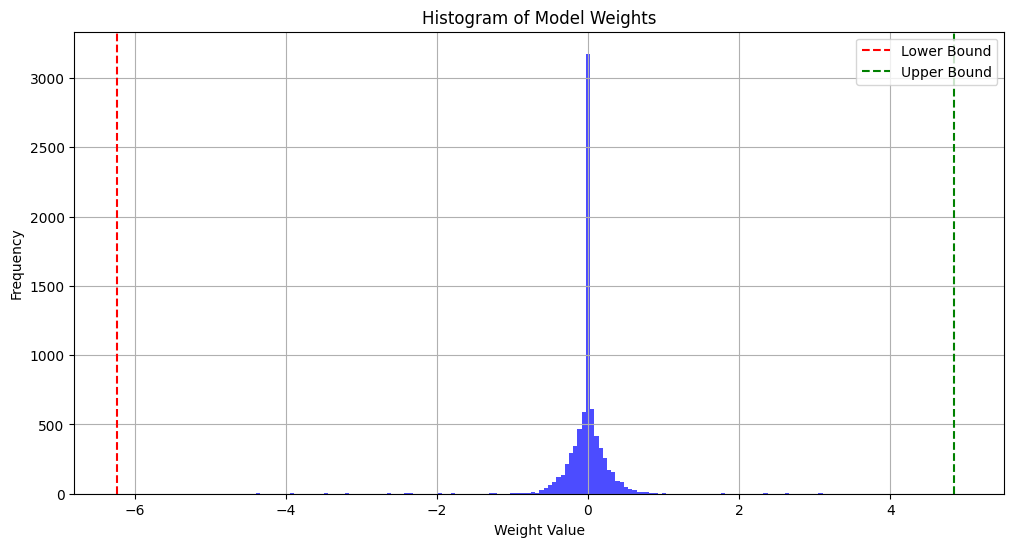

Lower Bound: -6.2362, Upper Bound: 4.8398
Quantized weights saved to quantized_weights_int8.npz


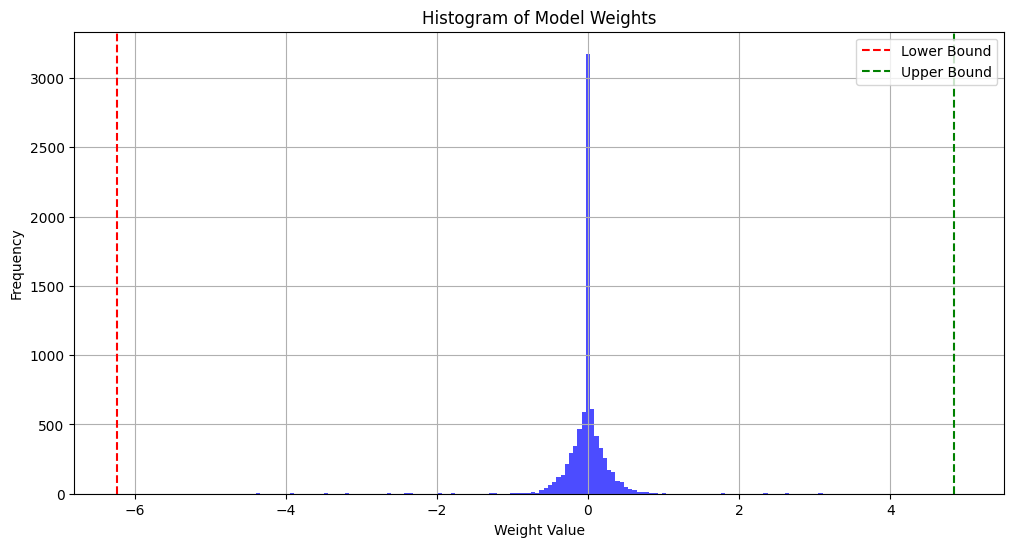

Lower Bound: -6.2362, Upper Bound: 4.8398
Quantized weights saved to quantized_weights_int8_2.npz
Quantized Weights:
wih: (784, 10), min: -22, max: 25
bih: (1, 10), min: -20, max: 10
who: (10, 10), min: -128, max: 102
bho: (1, 10), min: -71, max: -15
Normal weights:
wih: (784, 10), min: -1.06289803981781, max: 1.2112243175506592
bih: (1, 10), min: -0.9975035786628723, max: 0.49849313497543335
who: (10, 10), min: -6.2362213134765625, max: 4.9516777992248535
bho: (1, 10), min: -3.4558627605438232, max: -0.7425631880760193
Dequantized Weights:
wih: (784, 10), min: -1.0718505382537842, max: 1.2180119752883911
bih: (1, 10), min: -0.9744095802307129, max: 0.48720479011535645
who: (10, 10), min: -6.2362213134765625, max: 4.969489097595215
bho: (1, 10), min: -3.4591541290283203, max: -0.7308071851730347
Dequantized Weights 2:
wih: (784, 10), min: -1.081642508506775, max: 1.211439609527588
bih: (1, 10), min: -0.9951111078262329, max: 0.519188404083252
who: (10, 10), min: -6.230260848999023, max

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def load_weights(filename="model_weights.npz"):
    data = np.load(filename)
    weights = {
        'wih': data['wih'],
        'bih': data['bih'],
        'who': data['who'],
        'bho': data['bho']
    }
    return weights

def plot_histogram(weights, percentage=0):
    # Concatenate all weights into one flat array
    all_weights = np.concatenate([
        weights['wih'].flatten(), weights['bih'].flatten(),
        weights['who'].flatten(), weights['bho'].flatten()
    ])
    
    # Compute histogram
    hist, bin_edges = np.histogram(all_weights, bins=100)
    
    # Cumulative histogram to find percentiles
    cumulative = np.cumsum(hist)
    total = cumulative[-1]
    
    lower_index = np.searchsorted(cumulative, percentage * total)
    upper_index = np.searchsorted(cumulative, (1 - percentage) * total)

    # Ensure indices are within bounds
    lower_index = min(lower_index, len(bin_edges) - 2)
    upper_index = min(upper_index, len(bin_edges) - 2)

    lower_bound = bin_edges[lower_index]
    upper_bound = bin_edges[upper_index]

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.hist(all_weights, bins=200, alpha=0.7, color='blue')
    plt.axvline(x=lower_bound, color='red', linestyle='dashed', label='Lower Bound')
    plt.axvline(x=upper_bound, color='green', linestyle='dashed', label='Upper Bound')
    plt.title('Histogram of Model Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Lower Bound: {lower_bound:.4f}, Upper Bound: {upper_bound:.4f}")
    return lower_bound, upper_bound

def quantize_INT8(weights, filename="quantized_weights_int8.npz", type_quantization="range_tuning"):
    """"Quantize weights to INT8 using range tuning or range tuning with centering."""

    # Load weights
    lower_bound, upper_bound = plot_histogram(weights)

    # Get magnitude of maximum weight
    all_weights = np.concatenate([
        weights['wih'].flatten(), weights['bih'].flatten(),
        weights['who'].flatten(), weights['bho'].flatten()
    ])
    max_weight = np.max(np.abs(all_weights))

    # Copy keys to quantized weights
    quantized_weights = {}
    scale = 0
    zero_point = 0
    if type_quantization == "range_tuning":
        # Xquan = round(x*2^(8-1) / max(|x|))
        for key in weights:
            quantized_weights[key] = np.clip(np.round(weights[key] * (2**(8-1) / max_weight)), -128, 127).astype(np.int8)
    elif type_quantization == "range_tuning_centering":
        scale = 2**(8) / (upper_bound - lower_bound)
        zero_point = - np.round(lower_bound * scale) - 2**(7)
        for key in weights:
            quantized_weights[key] = np.clip(np.round(weights[key] * scale + zero_point), -128, 127).astype(np.int8)

    # Save quantized weights to file
    np.savez(
        filename,
        wih=quantized_weights['wih'],
        bih=quantized_weights['bih'],
        who=quantized_weights['who'],
        bho=quantized_weights['bho']
    )
    print(f"Quantized weights saved to {filename}")
    return quantized_weights, scale, zero_point, lower_bound, upper_bound, max_weight

def dequantize_INT8(quantized_weights, type_quantization="range_tuning", scale=0, zero_point=0, lower_bound=0, upper_bound=0, max_weight=0):
    """Dequantize weights from INT8 back to original values."""
    dequantized_weights = {}
    if type_quantization == "range_tuning":
        for key in quantized_weights:
            dequantized_weights[key] = quantized_weights[key] * (max_weight / (2**(8-1)))
    elif type_quantization == "range_tuning_centering":
        for key in quantized_weights:
            dequantized_weights[key] = (quantized_weights[key] - zero_point) / scale
    return dequantized_weights


# Load weights from file
weights = load_weights("weights_fp32.npz")

# Plot histogram and quantize weights
quantized_weights, scale, zero_point, lower_bound,  upper_bound, max_weight = quantize_INT8(weights, filename="quantized_weights_int8.npz")
quamtized_weights_2, scale_2, zero_point_2, lower_bound_2, upper_bound_2, max_weight_2 = quantize_INT8(weights, filename="quantized_weights_int8_2.npz", type_quantization="range_tuning_centering")

print("Quantized Weights:")
for key in quantized_weights:
    print(f"{key}: {quantized_weights[key].shape}, min: {quantized_weights[key].min()}, max: {quantized_weights[key].max()}")

print("Normal weights:")
for key in weights:
    print(f"{key}: {weights[key].shape}, min: {weights[key].min()}, max: {weights[key].max()}")

print("Dequantized Weights:")
dequantized_weights = dequantize_INT8(quantized_weights, type_quantization="range_tuning", scale=scale, zero_point=zero_point, lower_bound=lower_bound, upper_bound= upper_bound, max_weight=max_weight)
for key in dequantized_weights:
    print(f"{key}: {dequantized_weights[key].shape}, min: {dequantized_weights[key].min()}, max: {dequantized_weights[key].max()}")

print("Dequantized Weights 2:")
dequantized_weights_2 = dequantize_INT8(quamtized_weights_2, type_quantization="range_tuning_centering", scale=scale_2, zero_point=zero_point_2, lower_bound=lower_bound_2, upper_bound= upper_bound_2, max_weight=max_weight_2)
for key in dequantized_weights_2:
    print(f"{key}: {dequantized_weights_2[key].shape}, min: {dequantized_weights_2[key].min()}, max: {dequantized_weights_2[key].max()}")



In [ ]:
#Load weights from binary file and create a new model
model_int8_1 = NeuralNetwork(input_size=input_size, hidden_size=h_size, output_size=output_size, dtype=np.int8)
model_int8_1.load_all_weights("quantized_weights_int8.npz")

model_int8_2 = NeuralNetwork(input_size=input_size, hidden_size=h_size, output_size=output_size, dtype=np.int8)
model_int8_2.load_all_weights("quantized_weights_int8_2.npz")

# Print range of quantized weights and biases


# Test the quantized model with the same input data
# Input data for testing
input_data_fp32 = X_test.astype(np.float32)

# Cuantize input data to INT8_range 
input_data_int8 = np.clip(np.round(input_data_fp32 * (2**(8-1) / max_weight)), -128, 127).astype(np.int8)
                          
# Cuantize input data to INT8_range_centering
input_data_int8_2 = np.clip(np.round(input_data_fp32 * scale_2 + zero_point_2), -128, 127).astype(np.int8)

# Test the models with the same input data
models = {
    "FP32": model_fp32,
    "INT8_range": model_int8_1,
    "INT8_range_centering": model_int8_2
}

# Store results
results = []

for model_name, model in models.items():
    start_forward = time.time()
    output = model.forward(input_data_fp32 if model_name == "FP32" else input_data_int8 if model_name == "INT8_range" else input_data_int8_2)
    end_forward = time.time()

    # Calculate accuracy
    predictions = np.argmax(output, axis=1)
    accuracy = np.mean(predictions == labels) * 100

    print(f"\nModel: {model_name}")
    print("Predictions: ", predictions)
    print("Labels: ", labels)

    # Get size of weights and biases in MB
    weights_size = (model.weights_input_hidden.nbytes + model.bias_input_hidden.nbytes +
                    model.weights_hidden_output.nbytes + model.bias_hidden_output.nbytes) / (1024 * 1024)


    results.append({
        "Model": model_name,
        "Forward Time All (ms)": round((end_forward - start_forward) * 1000, 2),
        "Forward Time One (ms)": round((end_forward - start_forward) * 1000, 2) / len(X_test),
        "Accuracy (%)": round(accuracy, 2),
        "Weights Size (MB)": round(weights_size, 2)
    })
    

# === Display results table ===
df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(df.to_string(index=False))



Model: FP32
Predictions:  [5 8 7 6 4 7 7 4 9 4 1 6 8 6 8 7 9 4 5 6 1 7 1 4 8 9 1 6 8 8 1 1 0 1 7 4 1
 6 1 0 6 2 3 0 5 5 4 5 0 3 7 2 5 4 2 1 1 5 5 6 3 5 5 1 0 7 8 9 6 1 5 0 5 0
 7 0 1 3 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 5]
Labels:  [3 8 7 6 8 7 7 4 9 4 1 8 2 6 8 7 9 4 5 6 1 7 1 1 8 9 1 6 8 8 2 1 0 1 7 7 1
 6 1 6 6 2 3 0 5 5 4 5 0 3 9 2 5 4 2 1 7 5 5 6 3 5 5 1 0 7 8 9 6 1 0 0 5 0
 7 0 1 9 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 3]


/tmp/ipykernel_32107/2825271730.py:36: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_32107/2825271730.py:32: RuntimeWarning: overflow encountered in scalar add
  result[i, j] += A[i, k] * B[k, j]



Model: INT8_range
Predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0]
Labels:  [3 8 7 6 8 7 7 4 9 4 1 8 2 6 8 7 9 4 5 6 1 7 1 1 8 9 1 6 8 8 2 1 0 1 7 7 1
 6 1 6 6 2 3 0 5 5 4 5 0 3 9 2 5 4 2 1 7 5 5 6 3 5 5 1 0 7 8 9 6 1 0 0 5 0
 7 0 1 9 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 3]

Model: INT8_range_centering
Predictions:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Labels:  [3 8 7 6 8 7 7 4 9 4 1 8 2 6 8 7 9 4 5 6 1 7 1 1 8 9 1 6 8 8 2 1 0 1 7 7 1
 6 1 6 6 2 3 0 5 5 4 5 0 3 9 2 5 4 2 1 7 5 5 6 3 5 5 1 0 7 8 9 6 1 0 0 5 0
 7 0 1 9 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 3]

Model Performance Comparison:
               Model  Forward Time All (ms)  Forward Time O

### Pruning
Besides reducing precision for the network weights, we can also decide to eliminate network connections that do not contribute significantly to the model. This can be achieved by simply removing the connections whose weights are closest to zero.

In this part of the lab you are asked to generate three pruned versions of the original model by setting to zero some of the weights:


*   Set to zero the smallest 10% of weights
*   Set to zero the smallest 30% of weights
*   Set to zero the smallest 50% of weights

Report the accuracy for each model against the estimated memory savings.



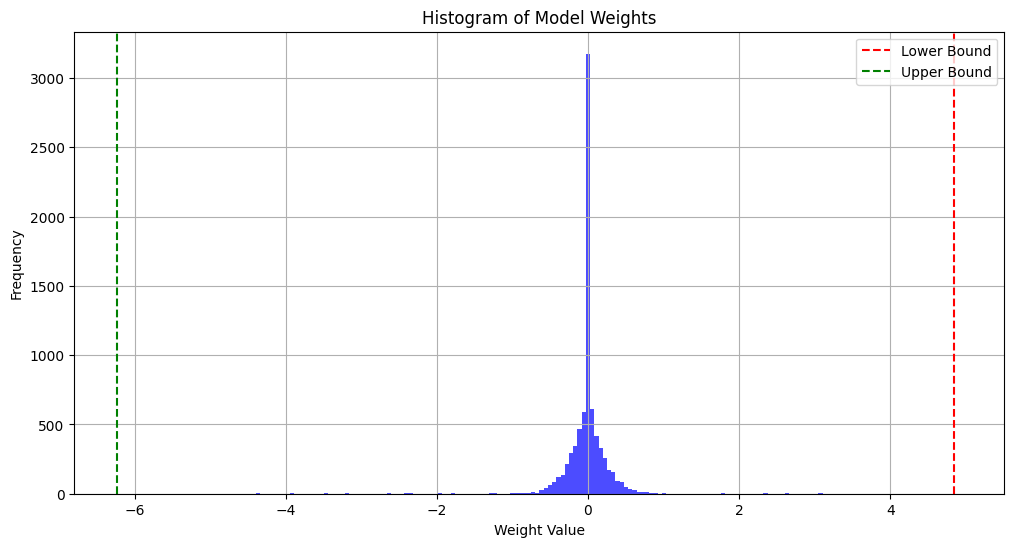

Lower Bound: 4.8398, Upper Bound: -6.2362
Pruned 10.0% of weights.
Threshold value: 0.0039


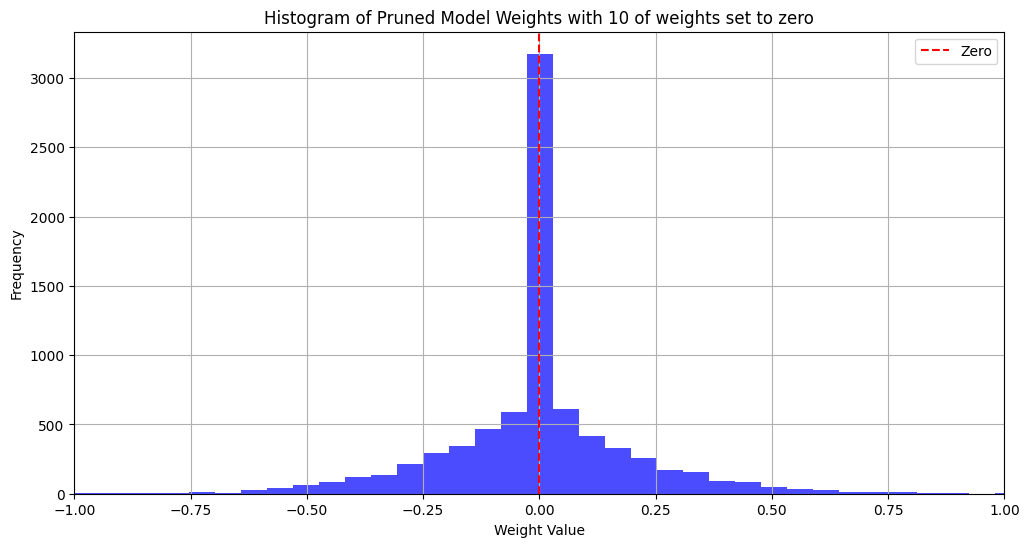

Pruned 30.0% of weights.
Threshold value: 0.0138


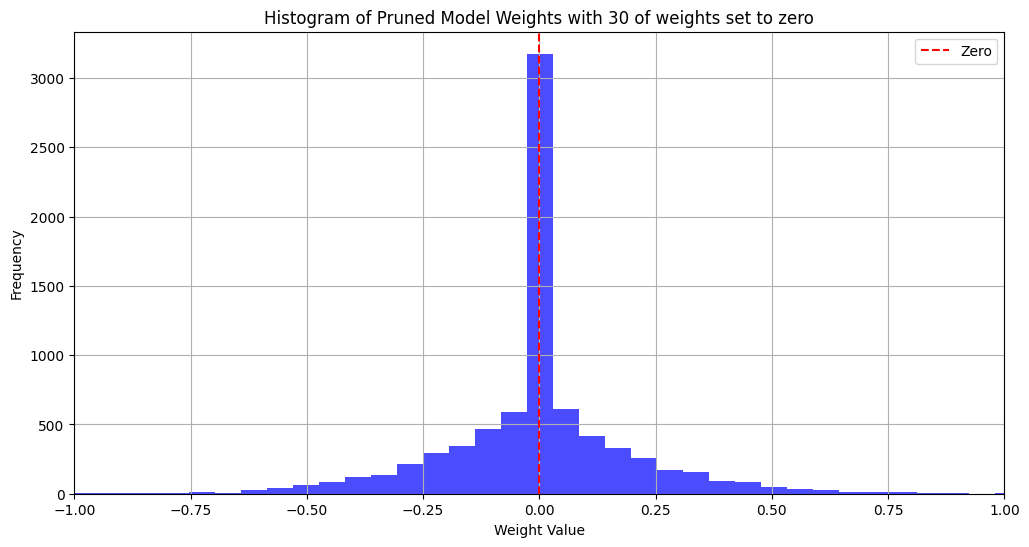

Pruned 50.0% of weights.
Threshold value: 0.0622


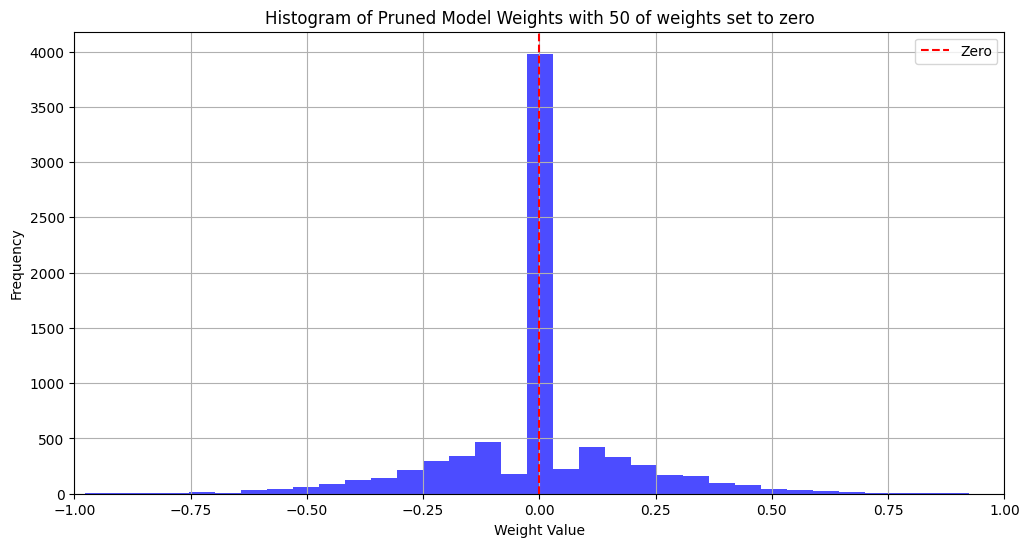


Model: Original
Predictions:  [5 8 7 6 4 7 7 4 9 4 1 6 8 6 8 7 9 4 5 6 1 7 1 4 8 9 1 6 8 8 1 1 0 1 7 4 1
 6 1 0 6 2 3 0 5 5 4 5 0 3 7 2 5 4 2 1 1 5 5 6 3 5 5 1 0 7 8 9 6 1 5 0 5 0
 7 0 1 3 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 5]
Labels:  [3 8 7 6 8 7 7 4 9 4 1 8 2 6 8 7 9 4 5 6 1 7 1 1 8 9 1 6 8 8 2 1 0 1 7 7 1
 6 1 6 6 2 3 0 5 5 4 5 0 3 9 2 5 4 2 1 7 5 5 6 3 5 5 1 0 7 8 9 6 1 0 0 5 0
 7 0 1 9 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 3]

Model: Pruned 10%
Predictions:  [5 8 7 6 4 7 7 4 9 4 1 6 8 6 8 7 9 4 5 6 1 7 1 4 8 9 1 6 8 8 1 1 0 1 7 4 1
 6 1 0 6 2 3 0 5 5 4 5 0 3 7 2 5 4 2 1 1 5 5 6 3 5 5 1 0 7 8 9 6 1 5 0 5 0
 7 0 1 3 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 5]
Labels:  [3 8 7 6 8 7 7 4 9 4 1 8 2 6 8 7 9 4 5 6 1 7 1 1 8 9 1 6 8 8 2 1 0 1 7 7 1
 6 1 6 6 2 3 0 5 5 4 5 0 3 9 2 5 4 2 1 7 5 5 6 3 5 5 1 0 7 8 9 6 1 0 0 5 0
 7 0 1 9 6 1 6 5 1 0 4 0 2 6 0 0 3 6 0 1 5 5 0 3 2 3]

Model: Pruned 30%
Predictions:  [5 8 7 6 4 7 7 4 9 4 1 6 8 6 8 7 9 4 5 6 1 7 1 4 8 9 1 6 8 8 7 1 0 1 

In [48]:
def prune_model(weights, percentage):
    # set to zero the smallest weights, according to the given percentage
    weights_pruned = {}
    flat_weights = [] #Flattened weights List
    for key in weights:
        # Flatten the weights and get the absolute values concatenated
        flat_weights.extend(np.abs(weights[key]).flatten())
    
    # Get the threshold value for pruning with the more smallest weights
    # Calculate the threshold value based on the percentage
    # If percentage is 0.1, we want to keep 90% of the weights more high values
    threshold_index = int(len(flat_weights) * (percentage))
    # Sort the weights and get the threshold value (Sorting in ascending order)
    # This will give us the value of the weight at the threshold index
    sorted_weights = np.sort(flat_weights)
    # Get the threshold value
    threshold = sorted_weights[threshold_index]

    for key in weights:
        #Apply the threshold to prune the weights
        weights_pruned[key] = np.where(np.abs(weights[key]) < threshold, 0, weights[key])
        
    print(f"Pruned {percentage*100}% of weights.")
    print(f"Threshold value: {threshold:.4f}")
    return weights_pruned

def plot_pruned_histogram(weights, percentage):
    # Concatenate all weights into one flat array
    all_weights = np.concatenate([
        weights['wih'].flatten(), weights['bih'].flatten(),
        weights['who'].flatten(), weights['bho'].flatten()
    ])
    
    # Compute histogram
    hist, bin_edges = np.histogram(all_weights, bins=100)
    
    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.hist(all_weights, bins=200, alpha=0.7, color='blue')
    plt.title('Histogram of Pruned Model Weights with %d of weights set to zero' % (percentage*100))
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.axvline(x=0, color='red', linestyle='dashed', label='Zero')
    plt.legend()
    plt.xlim(-1, 1)
    
    plt.show()


# Load weights from file
weights = load_weights("weights_fp32.npz")
# Plot histogram of original weights
plot_histogram(weights, percentage=1)
# Prune model weights
weights_pruned_10 = prune_model(weights, percentage=0.1)
plot_pruned_histogram(weights_pruned_10, percentage=0.1)
weights_pruned_30 = prune_model(weights, percentage=0.3)
plot_pruned_histogram(weights_pruned_30, percentage=0.3)
weights_pruned_50 = prune_model(weights, percentage=0.5)
plot_pruned_histogram(weights_pruned_50, percentage=0.5)
# Save pruned weights to binary files


#Load pruned weights
model_fp32_pruned_10 = NeuralNetwork(input_size=input_size, hidden_size=h_size, output_size=output_size, dtype=np.float32)
model_fp32_pruned_10.weights_input_hidden = weights_pruned_10['wih']
model_fp32_pruned_10.bias_input_hidden = weights_pruned_10['bih']
model_fp32_pruned_10.weights_hidden_output = weights_pruned_10['who']
model_fp32_pruned_10.bias_hidden_output = weights_pruned_10['bho']
model_fp32_pruned_30 = NeuralNetwork(input_size=input_size, hidden_size=h_size, output_size=output_size, dtype=np.float32)
model_fp32_pruned_30.weights_input_hidden = weights_pruned_30['wih']
model_fp32_pruned_30.bias_input_hidden = weights_pruned_30['bih']
model_fp32_pruned_30.weights_hidden_output = weights_pruned_30['who']
model_fp32_pruned_30.bias_hidden_output = weights_pruned_30['bho']
model_fp32_pruned_50 = NeuralNetwork(input_size=input_size, hidden_size=h_size, output_size=output_size, dtype=np.float32)
model_fp32_pruned_50.weights_input_hidden = weights_pruned_50['wih']
model_fp32_pruned_50.bias_input_hidden = weights_pruned_50['bih']
model_fp32_pruned_50.weights_hidden_output = weights_pruned_50['who']
model_fp32_pruned_50.bias_hidden_output = weights_pruned_50['bho']

models = {
    "Original": model_fp32,
    "Pruned 10%": model_fp32_pruned_10,
    "Pruned 30%": model_fp32_pruned_30,
    "Pruned 50%": model_fp32_pruned_50
}

# Store results
results = []

for model_name, model in models.items():
    start_forward = time.time()
    output = model.forward(input_data_fp32)
    end_forward = time.time()

    # Calculate accuracy
    predictions = np.argmax(output, axis=1)
    accuracy = np.mean(predictions == labels) * 100

    print(f"\nModel: {model_name}")
    print("Predictions: ", predictions)
    print("Labels: ", labels)

    # Get size of weights and biases in MB
    weights_size = (model.weights_input_hidden.nbytes + model.bias_input_hidden.nbytes +
                    model.weights_hidden_output.nbytes + model.bias_hidden_output.nbytes) / (1024 * 1024)


    results.append({
        "Model": model_name,
        "Forward Time All (ms)": round((end_forward - start_forward) * 1000, 2),
        "Forward Time One (ms)": round((end_forward - start_forward) * 1000, 2) / len(X_test),
        "Accuracy (%)": round(accuracy, 2),
        "Weights Size (MB)": round(weights_size, 2)
    })

# === Display results table ===
df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(df.to_string(index=False))


## Analysis

Discuss the following questions based on the lab experiments and the theory studied:


*   What are the advantages an disadvantages of storing model weights in different formats?
*   How much reduction in model memory requirements can be achieved by each of the versions obtained?
*   What are the posible computational advantages of the obtained models and how do they depend on the hardware?

